
# PyTorch VAE implementation


This notebook implements a standard VAE, trained on the MNIST dataset. We visualise the latent space, and visualise an interpolation in the latent space by observing a hand-written 9 transfrom into a 3. 


### Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)),cmap='Greys_r')

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# Set a random seed to ensure that results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./VAE/MNIST'):
    os.makedirs('./VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [20]:
# Hyper-parameters
num_epochs = 60
learning_rate  = 1e-3
batch_size = 128
latent_dim = 25

transform = transforms.Compose([
     transforms.ToTensor(),
])

# denorm function to visualise images
def denorm(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x



## Data loading


In [21]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './VAE/MNIST/image_original.png')

## Model Definition

In [22]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.input_dim),
            nn.Sigmoid()  # normalises between 0 and 1
        )

        self.fc_mu = nn.Linear(
            self.hidden_dim, self.latent_dim)  # to calculate mean
        self.fc_log_var = nn.Linear(
            self.hidden_dim, self.latent_dim)  # to calculate logvar

    def encode(self, x):
        x = self.encoder(x)  # encode
        return self.fc_mu(x), self.fc_log_var(x)  # extract mean and logvar

    def reparametrize(self, mu, logvar):
        # Can't back-propagate through sampling layer, so reparametrize
        # trick used. Stochastic samples are given as the input to the
        # network, and scaled to simulate sampling from the distribution

        # creates tensor of same size as mu, randomly populated from ~N(0,1)
        rand_sample = torch.randn_like(mu)
        var = torch.exp(logvar)
        std = var**0.5
        z = rand_sample*std + mu  # psuedo sample
        return z

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    def forward(self, x):

        x = x.view(-1, self.input_dim)  # flatten to 1x784 row vector
        mu, logvar = self.encode(x)  # return mu and logvar after encoder pass
        z = self.reparametrize(mu, logvar)  # sample from latent space
        x_re = self.decode(z)  # decode
        return x_re, mu, logvar


model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 658834
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (fc_mu): Linear(in_features=400, out_features=25, bias=True)
  (fc_log_var): Linear(in_features=400, out_features=25, bias=True)
)


## Training loop


From a probabilistic viewpoint, the task of the VAE is to generate new samples that follow the same distribution of the training set. It is assumed that the training data is generated from a latent representation $z$. The aim of the VAE is therefore to maximise the likelihood of training data with respect to the network's weights. However, approximating the likelihood of  the training data is an intractable problem. Therefore, an 'encoder' network $(q_\phi(z|x))$ is used to approximate the posterior probability $p_\theta(z|x)$, where $z$ is the latent space and $x$ is the data. Using the encoder and decoder networks as approximations, a lower bound to the log likelihood over the data can be calculated. This lower bound should be maximised during training - the inverse is therefore used as the loss function in my implementation.

The loss function used in my implementation was made up of two parts:
- Binary cross entropy loss to miniminse the expected negative log likelihood of $p(x|z)$. This serves as a reconstruction loss and encourages the decoder to learn to reconstruct the data as close as possible to the training distribution.

- The Kullbach-Leibler (KL) divergence between the distrubtion approximated by the encoder ($q_\theta(z|x)$) and the latent space distribution $p(z)$. This acts as a regularizer, penalising the network if $p(z)$ and $q_\theta(z|x)$ become too similar - i.e. it encourages diversity in the latent space representations. The KL divergence was calculated according to the formula in the appendix of the paper "Auto-Encoding Variational Bayes, Kingma and Welling, 2014"


In [23]:
def loss_function_VAE(x_re, x, mu, logvar):

    # binary cross entropy
    bce_loss = F.binary_cross_entropy(x_re, x.view(-1, 784), reduction='sum')

    # Sum KL div across batch
    KL_div = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))

    if KL_div.item() < 3000:
        KL_div = torch.tensor(3000, dtype=torch.float)

    return bce_loss, KL_div


# Loss trackers
total_loss_log_tr = []
bce_loss_log_tr = []
KL_div_log_tr = []

total_loss_log_te = []
bce_loss_log_te = []
KL_div_log_te = []


model.train()
for epoch in range(num_epochs):

    train_loss = 0
    bce = 0
    KL = 0
    idx = 1
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        
        # forward
        recon_batch, mu, logvar = model(img)
        bce_loss, KL_div = loss_function_VAE(recon_batch, img, mu, logvar)
        loss = bce_loss + KL_div

        # backward
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_loss.item()
        KL += KL_div.item()

    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1,
                                              num_epochs, train_loss / len(loader_train.dataset)))
    recon = denorm(model(fixed_input.to(device))[0])
    save_image(recon.float(), './CW_VAE/reconstructed_epoch_{}.png'.format(epoch))

    total_loss_log_tr.append(train_loss/len(loader_train.dataset))
    bce_loss_log_tr.append(bce/len(loader_train.dataset))
    KL_div_log_tr.append(KL/idx)

    # Testing
    with torch.no_grad():
        test_loss = 0
        bce_t = 0
        KL_t = 0
        idx = 0
        for batch_idx_t, data_t in enumerate(loader_test):
            img, _ = data_t
            img = img.to(device)
            recon_batch, mu, logvar = model(img)
            bce_loss, KL_div = loss_function_VAE(recon_batch, img, mu, logvar)
            loss = bce_loss + KL_div

            test_loss += loss.item()
            bce_t += bce_loss.item()
            KL_t += KL_div.item()
            idx += 1

        total_loss_log_te.append(test_loss/len(loader_test))
        bce_loss_log_te.append(bce/len(loader_test))
        KL_div_log_te.append(KL_t/idx)

    idx += 1

# save the model
torch.save(model.state_dict(), './VAE/MNIST/VAE_model.pth')

epoch [1/60], loss:169.4790
epoch [2/60], loss:123.1548
epoch [3/60], loss:115.3959
epoch [4/60], loss:112.1765
epoch [5/60], loss:110.3504
epoch [6/60], loss:109.1164
epoch [7/60], loss:108.1981
epoch [8/60], loss:107.4659
epoch [9/60], loss:106.9137
epoch [10/60], loss:106.4887
epoch [11/60], loss:106.0795
epoch [12/60], loss:105.7507
epoch [13/60], loss:105.4521
epoch [14/60], loss:105.2267
epoch [15/60], loss:105.0190
epoch [16/60], loss:104.7593
epoch [17/60], loss:104.6229
epoch [18/60], loss:104.4121
epoch [19/60], loss:104.2424
epoch [20/60], loss:104.0870
epoch [21/60], loss:103.9425
epoch [22/60], loss:103.8747
epoch [23/60], loss:103.7287
epoch [24/60], loss:103.6627
epoch [25/60], loss:103.4941
epoch [26/60], loss:103.4184
epoch [27/60], loss:103.3548
epoch [28/60], loss:103.2539
epoch [29/60], loss:103.1535
epoch [30/60], loss:103.1033
epoch [31/60], loss:103.0134
epoch [32/60], loss:102.9702
epoch [33/60], loss:102.8898
epoch [34/60], loss:102.8275
epoch [35/60], loss:102

## Loss Curves


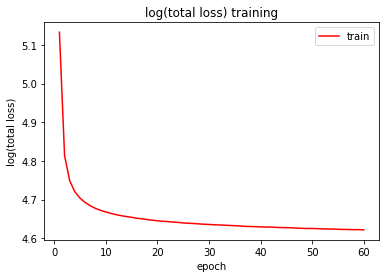

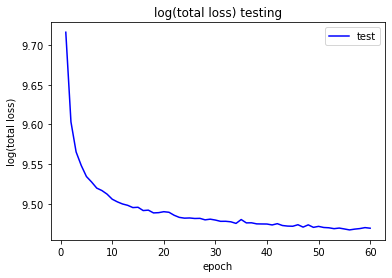

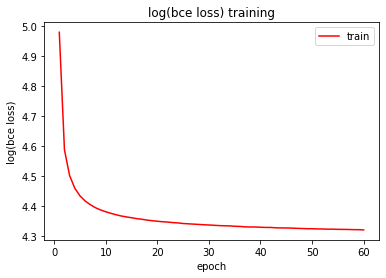

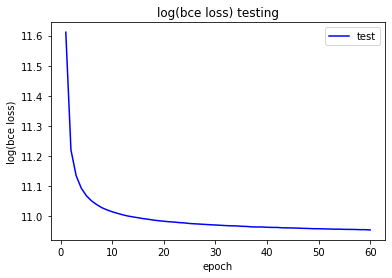

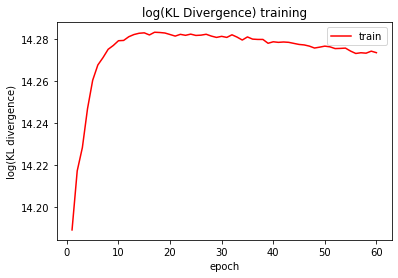

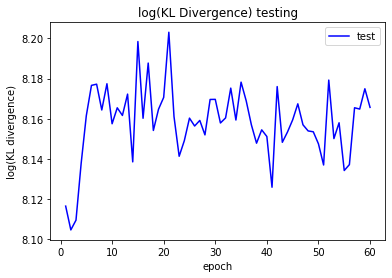

In [24]:

plt.plot(range(1, num_epochs + 1), np.log(total_loss_log_tr), c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('log(total loss)')
plt.title('log(total loss) training')
plt.show()

plt.plot(range(1, num_epochs + 1), np.log(total_loss_log_te), c='b', label='test')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('log(total loss)')
plt.title('log(total loss) testing')
plt.show()


plt.plot(range(1, num_epochs + 1), np.log(bce_loss_log_tr), c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('log(bce loss)')
plt.title('log(bce loss) training')
plt.show()

plt.plot(range(1, num_epochs + 1), np.log(bce_loss_log_te), c='b', label='test')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('log(bce loss)')
plt.title('log(bce loss) testing')
plt.show()

plt.plot(range(1, num_epochs + 1), np.log(KL_div_log_tr), c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('log(KL divergence)')
plt.title('log(KL Divergence) training')
plt.show()

plt.plot(range(1, num_epochs + 1), np.log(KL_div_log_te), c='b', label='test')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('log(KL divergence)')
plt.title('log(KL Divergence) testing')
plt.show()


The plots above show log-likelihood loss decreasing with training time. Intuitively this is to be expected, as the log-likelihood loss acts as a reconstruction loss, encouraging the decoder to reconstruct the data. It is therefore desirable and expected for this loss to decrease.

The plots of KL divergence, however, show it sharply increase for the first ~10 epochs before leveling off for the remainder of training. This is undersirable, as the KL divergence term of the loss function can be thought of as a regularization term which penalises the latent space for being too similar to the prioir distribution $p(x|z)$. If this term is too small, the network is not discouraged from just assigning the latent space to the pixel values and thus not learning to encode useful information. A way to mitigate this would be to threshold the value of KL divergence while calculating the loss. This was implemented, however, it did not work very well. Other, more sophisticated techniques, can be used such as using a $\delta$-VAE, as described in the paper 'Preventing Posterior Collapse with $\delta$-VAEs, Razavi et al 2019' (https://openreview.net/pdf?id=BJe0Gn0cY7)



In [ ]:
# load the model
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.title("Original Images")
show(img)
plt.savefig('original_images.png')

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model(fixed_input.to(device))[0]
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    plt.title("Reconstructed Images")
    show(recon_batch)
    plt.savefig('reconstructed.png')

model.eval()
n_samples = 256
z = torch.randn(n_samples, latent_dim).to(device)

with torch.no_grad():
    samples = model(fixed_input.to(device))[0]
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(8, 8))
    plt.title("Generated digits")
    show(samples)
    plt.savefig('generated.png')

![original](original_images.png)
![reconstructed](reconstructed.png)
![generated](generated.png)



## Qualitative analysis of the learned representations


### Visualise latent representations

Here I extract the latent representations of the test set, and use T-SNE to condense them into 2D dimensions, and visualise them

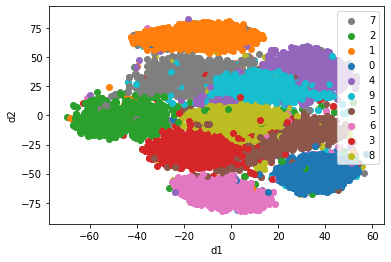

In [30]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# load the model
model.load_state_dict(torch.load('./VAE/MNIST/VAE_model.pth'))


loader_test = DataLoader(test_dat, 10000, shuffle=False)


with torch.no_grad():
    for batch_idx_t, data_t in enumerate(loader_test):
        sample_inputs, sample_labels = data_t

        # Retrieve mu, logvar
        sample_inputs = sample_inputs.view(-1, 28*28)
        # return mu and logvar after encoder pass
        mu, logvar = model.encode(sample_inputs.to(device))
        z = model.reparametrize(mu, logvar)

        z_embedded = TSNE(n_components=2).fit_transform(
            z.cpu())  # z_embedded shape is 128,2

        if batch_idx_t == 5:
            break


fig = plt.figure()
colors_lst = []

def plot_point(color, colors_lst):
    if color in colors_lst:
        plt.scatter(img[0], img[1], c=f'C{color}')
    else:
        plt.scatter(img[0], img[1], c=f'C{color}', label=color)


for idx, img in enumerate(z_embedded):
    color = sample_labels[idx].item()
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0
    count6 = 0
    count7 = 0
    count8 = 0
    count9 = 0

    if color == 0 and count0 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    elif color == 1 and count1 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    elif color == 2 and count2 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    elif color == 3 and count3 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    if color == 4 and count4 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    elif color == 5 and count5 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    elif color == 6 and count6 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    elif color == 7 and count7 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    if color == 8 and count8 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
    elif color == 9 and count9 < 10:
        plot_point(color, colors_lst)
        colors_lst.append(color)
plt.xlabel('d1')
plt.ylabel('d2')

plt.legend(loc='upper right')
plt.show()




It can be seen from the plot that the encoder clusters similar digits into similar locations fairly well, when the latent space is projected onto 2 dimensions. Particularly interesting is that the 'Ones' are clustered near the 'Sevens' - this makes intuitive sense as a handwritten 1 is similar to a handwritten 7. Similar patterns can be seen with 'nines' and 'fours'. It is also noted that the cluster for 'eights' is in the middle. Again, this seems plausible, as a hand written 8 may look similar to many other digits (0s,9s,5s,3s). More information may be gleamed from visualising the latent space in 3D. This was attempted, but the plot was not sufficiently clear in the Jupyter notebook.

### Interpolation in latent space

Here, I interpolate between the numbers 9 and 3 in the latent space. We observe that there is a transformation from a hand-written 9 to a 3

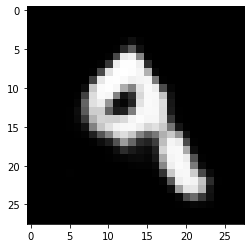

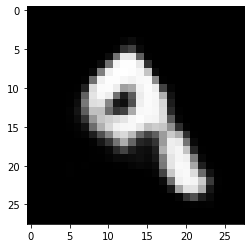

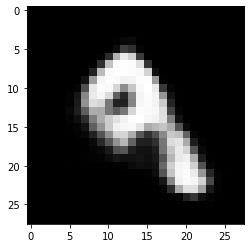

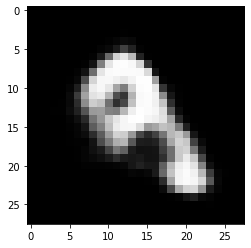

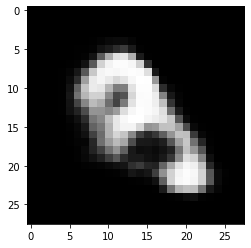

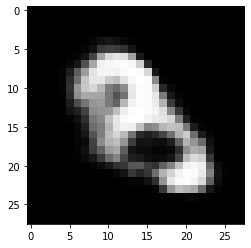

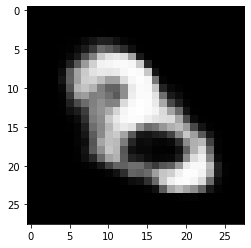

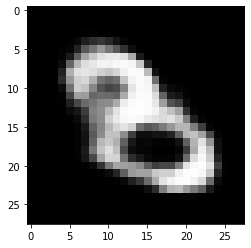

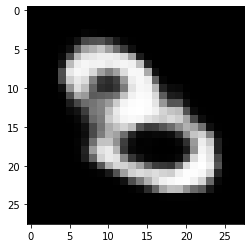

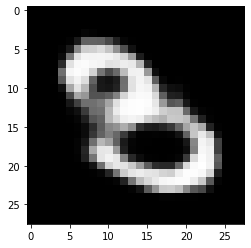

In [26]:
# *CODE FOR PART 1.3b IN THIS CELL*

def show_int(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(npimg,cmap='Greys_r')
    
    
def denorm_int(x):
    x = x.clamp(0, 1)
    x = x.view(1, 28, 28)
    return x


# load the model
model.load_state_dict(torch.load('./VAE/MNIST/VAE_model.pth'))
sample_inputs, sample_labels = next(iter(loader_test))
fixed_input = sample_inputs[:, :, :, :]
with torch.no_grad():

    z9 = sample_inputs[7,:]
    z3 = sample_inputs[18,:]

    z9= z9.view(1,-1) #flatten to 1x784 row vector 
    z3= z3.view(1,-1) #flatten to 1x784 row vector 
    
    mu9, logvar9 = model.encode(z9.to(device)) #return mu and logvar after encoder pass
    z9 = model.reparametrize(mu9,logvar9) #sample from latent space 
    
    mu3, logvar3 = model.encode(z3.to(device)) #return mu and logvar after encoder pass
    z3 = model.reparametrize(mu3,logvar3) #sample from latent space 
    
    z3_centroid = z3.mean(axis=0)
    z9_centroid = z9.mean(axis=0)

    z9_3 = z3_centroid - z9_centroid
    
    for i in range(10):
        alpha = i/10
        z_interp = z9_centroid + alpha*z9_3

        img = model.decode(z_interp.to(device))
        img.unsqueeze(0)
        img = (denorm_int(img))
        img = img.squeeze()
        plt.figure()
        show_int(img)
